In [2]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool
import os

In [3]:
def CCC(y_pred, y_true):
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    
    return numerator / denominator


In [4]:
def load_data(rna_path, tag_path, protein_path, atac_path, rna_onlist, atac_onlist):
    rna = ad.read_h5ad(rna_path)
    tag = ad.read_h5ad(tag_path)
    protein = ad.read_h5ad(protein_path)
    atac = ad.read_h5ad(atac_path)
    
    # map between the atac barcodes and the rna barcodes
    gwl = pd.read_csv(rna_onlist, header=None, names=["rna"]) # 10x_version3_whitelist.txt
    awl = pd.read_csv(atac_onlist, header=None, names=["ata"]) # 737K-arc-v1_rc.txt
    
    # Map BCs between RNA and ATAC
    bcmap = pd.concat([awl, gwl], axis=1).set_index("ata")
    
    atac.obs["ata_bcs"] = atac.obs.index.values
    atac.obs["rna_bcs"] = atac.obs.index.map(bcmap["rna"])
    atac.obs.set_index("rna_bcs", inplace=True)
    
    common = np.intersect1d(
                np.intersect1d(
                    np.intersect1d(
                        rna.obs.index.values, atac.obs.index.values), 
                    tag.obs.index.values), 
                protein.obs.index.values)
    
    rna = rna[common].copy()   
    tag = tag[common].copy()  
    protein = protein[common].copy()   
    atac = atac[common].copy()
    
    return tag,rna,atac,protein

In [100]:
plt.rcParams['font.size'] = '12'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '24'
legend_font = '18'
title_font = '30'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [6]:
base = "/home/mffang/data/counts/Dogmaseq-dig"
TAG,RNA,ATAC,PROTEIN = load_data(
    os.path.join(base, "RNA/counts_filtered/adata.h5ad"),
    os.path.join(base, "tag/counts_unfiltered/adata.h5ad"),
    os.path.join(base, "protein/counts_unfiltered/adata.h5ad"),
    os.path.join(base, "atac/counts_mult/adata.h5ad"),
    os.path.join(base, "RNA-737K-arc-v1.txt"),
    os.path.join(base, "ATA-737K-arc-v1_rc.txt"),
)

In [7]:
mtx = RNA.layers['mature'].toarray() + RNA.layers['ambiguous'].toarray() + RNA.layers['nascent'].toarray()

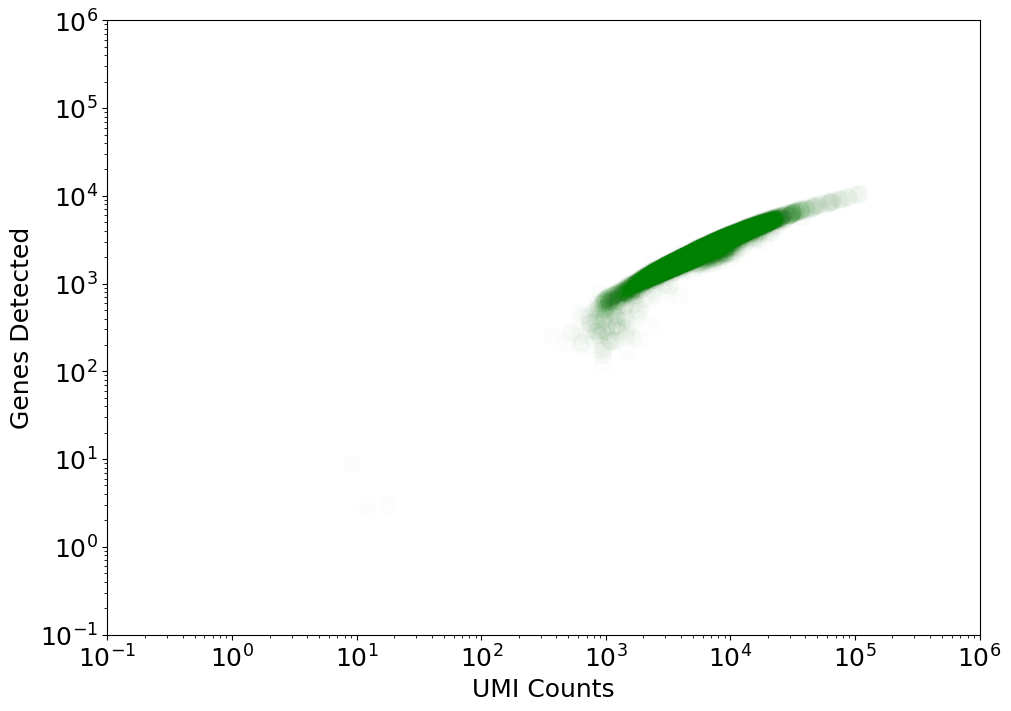

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", alpha=0.01)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.1,1000000))
ax.set_ylim((0.1,1000000))

plt.show()

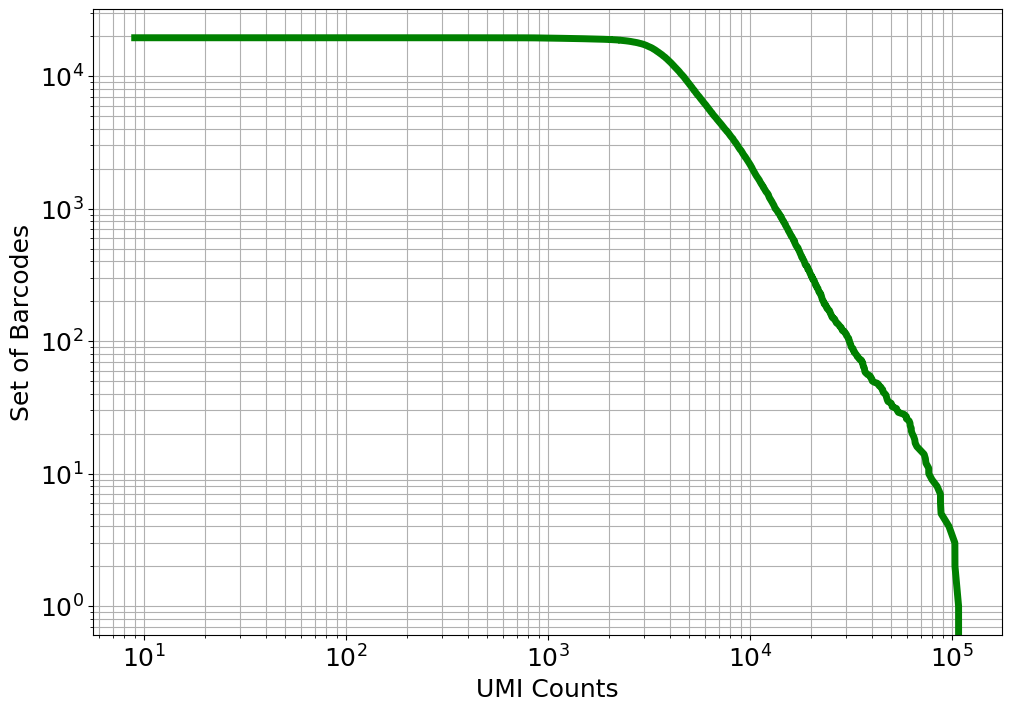

In [9]:
# Create the "knee plot"
knee = np.sort((np.array(mtx.sum(axis=1))).flatten())[::-1]
fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)),linewidth=5, color="g")
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [10]:
import statistics

statistics.median(mtx.sum(axis=1))

4739.0

In [11]:
rna = RNA[np.array(mtx.sum(axis=1))>1000]
rna

View of AnnData object with n_obs × n_vars = 19392 × 62754
    layers: 'ambiguous', 'mature', 'nascent'

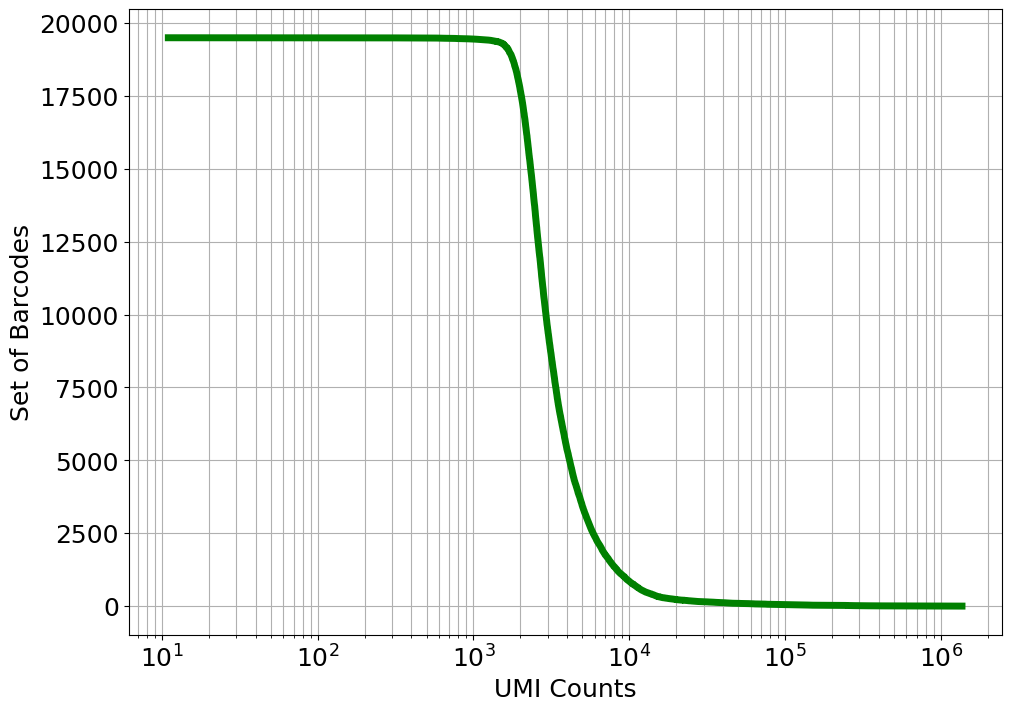

In [12]:
mtx = PROTEIN.X.toarray()

# Create the "knee plot"
knee = np.sort((np.array(mtx.sum(axis=1))).flatten())[::-1]
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(knee, range(len(knee)),linewidth=5, color="g")
ax.set_xscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

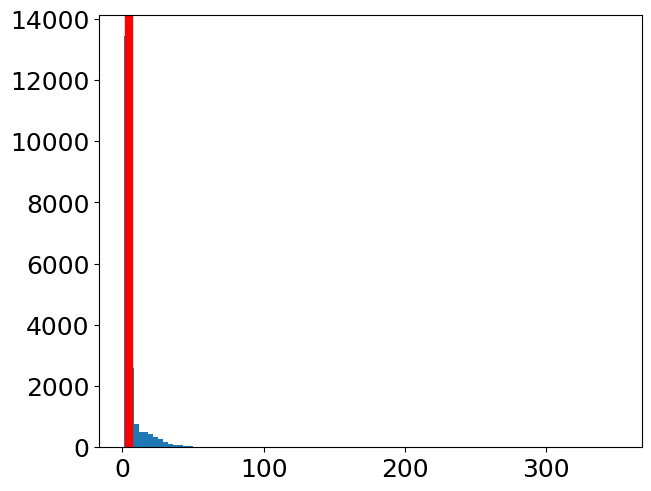

In [13]:
tag_ = np.sort(TAG.X.toarray(),axis=1)
plt.axvline(x=5,c='r');
plt.hist(tag_[:,-1]/tag_[:,-2],bins=100);

In [76]:
tag = TAG[tag_[:,-1]/tag_[:,-2] > 3]

In [77]:
common = np.intersect1d(
                np.intersect1d(
                    np.intersect1d(
                        rna.obs.index.values, ATAC.obs.index.values), 
                    tag.obs.index.values), 
                PROTEIN.obs.index.values)
    
rna = rna[common].copy()   
tag = TAG[common].copy()  
protein = PROTEIN[common].copy()   
atac = ATAC[common].copy()
rna

AnnData object with n_obs × n_vars = 8826 × 62754
    obs: 'tag'
    var: 'id'
    layers: 'ambiguous', 'mature', 'nascent'

In [78]:
common = np.intersect1d(
                np.intersect1d(
                    np.intersect1d(
                        rna.obs.index.values, atac.obs.index.values), 
                    tag.obs.index.values), 
                protein.obs.index.values)
    
rna = rna[common].copy()   
tag = tag[common].copy()  
protein = protein[common].copy()   
atac = atac[common].copy()
rna

AnnData object with n_obs × n_vars = 8826 × 62754
    obs: 'tag'
    var: 'id'
    layers: 'ambiguous', 'mature', 'nascent'

In [79]:
clusters = np.argmax(tag.X.toarray(),axis=1)
rna.obs['tag']=clusters
rna.obs

,tag
barcode,
AAACAGCCAACCTAAT,5
AAACAGCCAAGGTCCT,1
AAACAGCCAGTAGCCT,4
AAACATGCACTCAACA,7
AAACATGCAGGTCCTG,1
...,...
TTTGTTGGTAGCAGCT,1
TTTGTTGGTAGCCTAA,0
TTTGTTGGTATTGGAT,2


In [80]:
rna.var

,id
gene_id,
ENSG00000279928.2,ENSG00000279928
ENSG00000228037.1,ENSG00000228037
ENSG00000142611.17,ENSG00000142611
ENSG00000284616.1,ENSG00000284616
ENSG00000157911.11,ENSG00000157911
...,...
ENSG00000271254.7,ENSG00000271254
ENSG00000275987.1,ENSG00000275987
ENSG00000268674.2,ENSG00000268674


In [18]:
rna_id = np.array([name.split('.')[0] for name in rna.var_names], dtype=str)
rna_id

array(['ENSG00000279928', 'ENSG00000228037', 'ENSG00000142611', ...,
       'ENSG00000268674', 'ENSG00000277475', 'ENSG00000275405'],
      dtype='<U15')

In [19]:
rna.var['id']=rna_id

In [20]:
protein.var

,feature_name
feature_id,
CD134-A0158,CD134-A0158
CD21-A0181,CD21-A0181
CD112-A0024,CD112-A0024
CD57-A0168,CD57-A0168
CD64-A0162,CD64-A0162
...,...
CD20-A0100,CD20-A0100
CD36-A0407,CD36-A0407
TIGIT-A0089,TIGIT-A0089


In [21]:
genes = np.array([name[:-6] for name in protein.var_names],dtype=str)
genes

array(['CD134', 'CD21', 'CD112', 'CD57', 'CD64', 'Rat-IgG2a-k-Ctrl',
       'CD16', 'HLA-DR', 'CD115', 'CD185', 'CD335', 'CD279', 'CD37',
       'CD99', 'LOX-1', 'CD31', 'CD41', 'CD49a', 'CD35', 'CD24',
       'HLA-DR-DP-DQ', 'Ig-light-chain-k', 'CD194', 'CD61', 'CX3CR1',
       'CD319', 'CD267', 'CD352', 'Mouse-IgG2b-k-Ctrl', 'CD162', 'CD155',
       'Rat-IgG1-k-Ctrl', 'CD116', 'CD152', 'CD79b', 'CD305', 'CD200',
       'CD142', 'CD109', 'Ig-light-chain-l', 'CD107a', 'CD137', 'CD72',
       'IgD', 'CD73', 'CD5', 'CLEC12A', 'CD223', 'CD195', 'CD83', 'CD95',
       'CD49d', 'CD71', 'ArmenianHamster-IgG-Ctrl', 'CD62P', 'CD146',
       'CD85j', 'CD268', 'CD278', 'TCR-ab', 'CD172a', 'CD314', 'CD48',
       'CD101', 'CD40', 'CD3', 'CD84', 'CD45RO', 'Mouse-IgG2a-k-Ctrl',
       'FceRIa', 'CD54', 'CD131', 'CD19', 'CD74', 'CD151', 'CD328',
       'KLRG1', 'CD123', 'CD94', 'CD52', 'CD11b', 'CD103', 'CD303',
       'CD63', 'CD1c', 'CD9', 'CD192', 'CD196', 'CD43',
       'Rat-IgG2b-k-Ctrl', 'CD27

In [22]:
import requests

def get_ensg_id(gene_name):
    base_url = "https://rest.ensembl.org"
    endpoint = f"/xrefs/symbol/human/{gene_name}"

    url = f"{base_url}{endpoint}"

    response = requests.get(url, headers={"Content-Type": "application/json"})

    if response.status_code == 200:
        data = response.json()
        if data:
            ensg_id = data[0]['id']
            return ensg_id
        else:
            return None
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return None
        
ensg_ids = []
# Example usage
for i,gene in enumerate(genes):
    gene_name = gene
    ensg_id = get_ensg_id(gene_name)
    ensg_ids.append(ensg_id)
    if not ensg_id:
        print(f"Failed to retrieve ENSG ID for {i}th gene {gene_name}")

Failed to retrieve ENSG ID for 5th gene Rat-IgG2a-k-Ctrl
Failed to retrieve ENSG ID for 7th gene HLA-DR
Failed to retrieve ENSG ID for 20th gene HLA-DR-DP-DQ
Failed to retrieve ENSG ID for 21th gene Ig-light-chain-k
Failed to retrieve ENSG ID for 28th gene Mouse-IgG2b-k-Ctrl
Failed to retrieve ENSG ID for 31th gene Rat-IgG1-k-Ctrl
Failed to retrieve ENSG ID for 39th gene Ig-light-chain-l
Failed to retrieve ENSG ID for 43th gene IgD
Failed to retrieve ENSG ID for 53th gene ArmenianHamster-IgG-Ctrl
Failed to retrieve ENSG ID for 59th gene TCR-ab
Failed to retrieve ENSG ID for 65th gene CD3
Failed to retrieve ENSG ID for 67th gene CD45RO
Failed to retrieve ENSG ID for 68th gene Mouse-IgG2a-k-Ctrl
Failed to retrieve ENSG ID for 89th gene Rat-IgG2b-k-Ctrl
Failed to retrieve ENSG ID for 93th gene Mouse-IgG1-k-Ctrl
Failed to retrieve ENSG ID for 106th gene IgE
Failed to retrieve ENSG ID for 107th gene Rat-IgG1-l-Ctrl
Failed to retrieve ENSG ID for 110th gene Podoplanin
Failed to retrieve ENSG

In [23]:
protein.var['id'] = ensg_ids
protein.var

,feature_name,id
feature_id,,
CD134-A0158,CD134-A0158,ENSG00000186827
CD21-A0181,CD21-A0181,ENSG00000117322
CD112-A0024,CD112-A0024,ENSG00000130202
CD57-A0168,CD57-A0168,ENSG00000109956
CD64-A0162,CD64-A0162,ENSG00000150337
...,...,...
CD20-A0100,CD20-A0100,ENSG00000156738
CD36-A0407,CD36-A0407,ENSG00000135218
TIGIT-A0089,TIGIT-A0089,ENSG00000181847


In [24]:
common_genes = protein.var['id'][protein.var['id'].isin(rna.var['id'])]
rna_gene_idx = np.array([ np.where(np.array(rna.var['id']) == ensg_id)[0][0] for ensg_id in common_genes])
protein_gene_idx = np.array([ np.where(np.array(protein.var['id']) == ensg_id)[0][0] for ensg_id in common_genes])

In [81]:
for i in range(8):
    print(rna.obs['tag'].isin([i]).sum())

1633
1749
1089
120
2568
1543
48
76


In [82]:
cluster_idx = (rna.obs['tag'].isin([1])) 
adata = rna[cluster_idx]
adata.layers['unspliced'] = adata.layers['nascent']
adata.layers['spliced'] = adata.layers['mature']
adata

AnnData object with n_obs × n_vars = 1749 × 62754
    obs: 'tag'
    var: 'id'
    layers: 'ambiguous', 'mature', 'nascent', 'unspliced', 'spliced'

## Calculate CV$^2$ of read depth

0.061973102 0.007341426


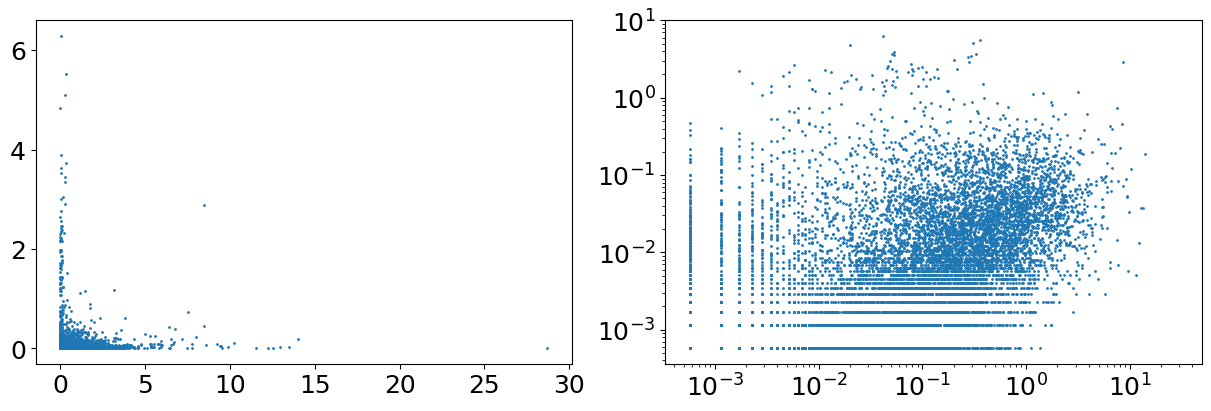

In [83]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

In [30]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.1) & (adata.layers["unspliced"].toarray().mean(0) > 0.1)

U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))

S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

A = adata.layers["ambiguous"][:,idx].toarray()
X = S + U + A
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

s estimated by normalized covariance of total U counts = 0.6537698476026578
s estimated by normalized covariance of total S counts = 0.8421714401216759
s estimated by normalized covariance of total counts = 0.67216226547981


s estimated by total counts = 0.6414549032122794
299 su= 0.5930628023984368
3176 ss= 0.7715857605619011
392 s= 0.5755512503279933


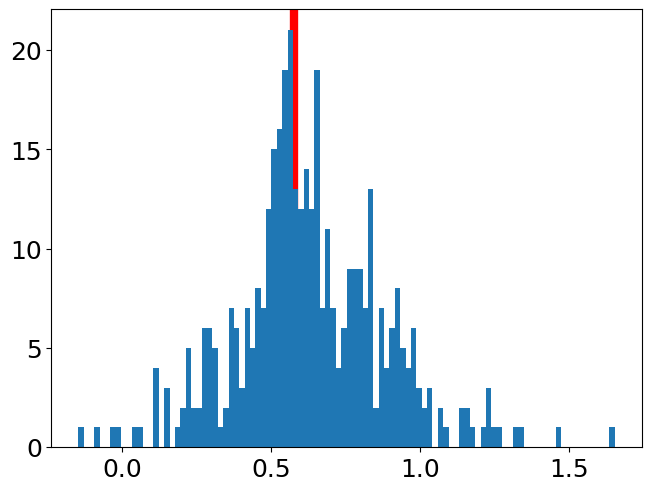

In [34]:
su, ss, sp = estimate_s(adata)

In [43]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.01) & (adata.layers["unspliced"].toarray().mean(0) > 0.01)
U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
A = adata.layers["ambiguous"][:,idx].toarray()
U.sum()*1e-4, S.sum()*1e-4, A.sum()*1e-4

(796.6679, 114.2309, 296.93960000000004)

Text(0.02, 0.5, 'CV$^2$')

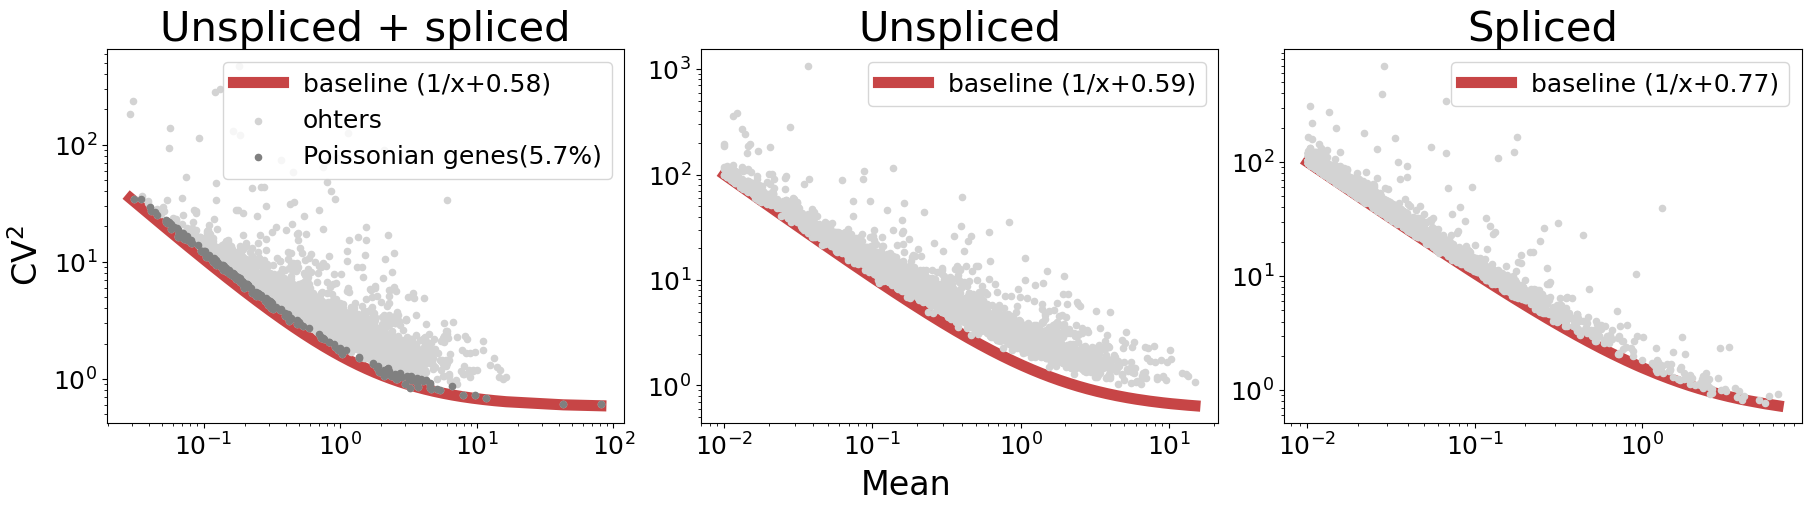

In [44]:
s = sp

X = U + S + A
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + s, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + s, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
#ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), 1/np.sort(S_mean) + s, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
#ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

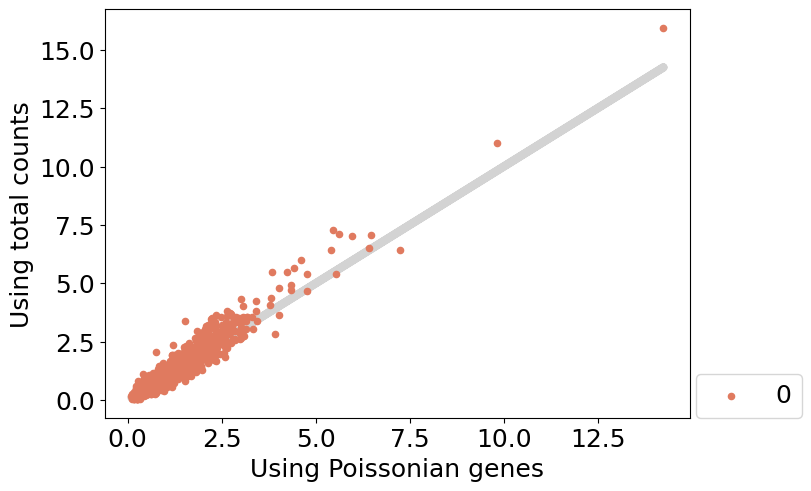

In [46]:
clusters = adata.obs['tag']
Clusters = set(clusters)
rd = X[:,Pgene_mask].mean(1)/X[:,Pgene_mask].mean()
rd_ = X.mean(1)/X.mean()
fig, ax = plt.subplots(1,1,figsize=(8,4.8))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    ax.scatter(rd[idx],rd_[idx],color=cmap_cluster(i),alpha=1,s=20,label=Cluster)
ax.plot(rd,rd,color='lightgray',zorder=0)
plt.xlabel('Using Poissonian genes',fontsize=legend_font)
plt.ylabel('Using total counts',fontsize=legend_font)
plt.legend(loc=(1.01,0),fontsize=legend_font)

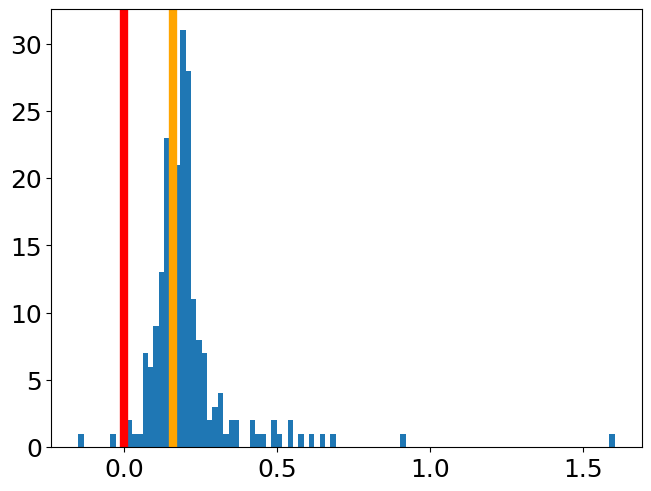

In [47]:
plt.hist((X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]-s*X_mean[Pgene_mask],bins=100);
plt.axvline(x=0,c='r')
plt.axvline(x=0.1*(1+s),c='orange')

# Check covariance relationships

In [84]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.1) & (adata.layers["unspliced"].toarray().mean(0) > 1)

U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
A = adata.layers["ambiguous"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = (cov_us)/S_mean/U_mean
zeta_us.shape

(165,)

## $Var(N_U)$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


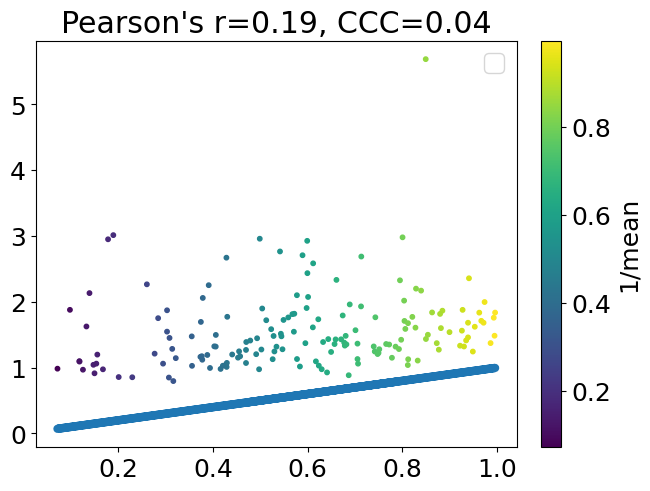

In [85]:
x = 1/U_mean
y = zeta_uu
plt.scatter(x,y,s=10,alpha=1,c=x)
plt.plot(x,x)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

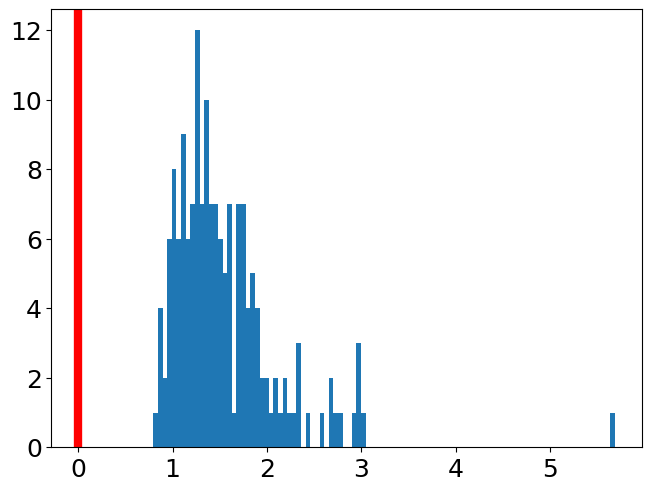

In [86]:
plt.hist(zeta_uu,bins=100);
plt.axvline(x=0,c='r')

## $Cov(N_u,N_s)$ 

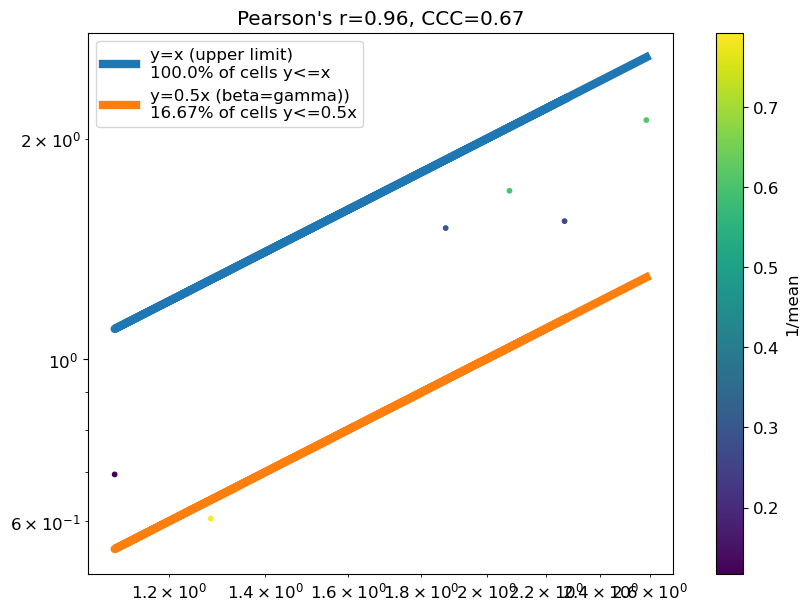

In [106]:
x=zeta_uu
y=zeta_us

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.loglog(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

## $Var(N_s)$ 

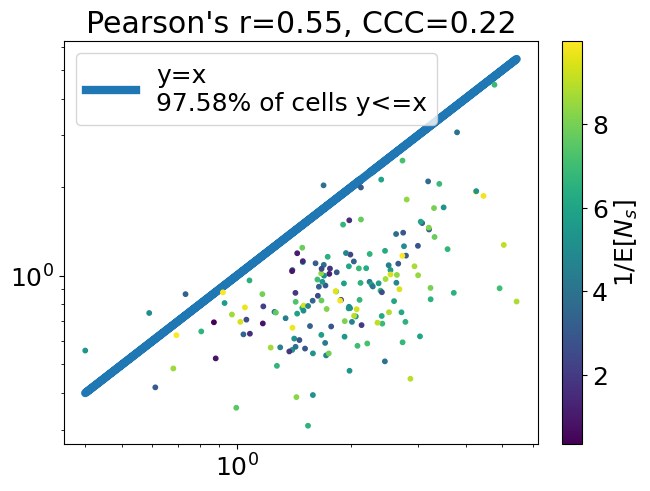

In [88]:
x=zeta_ss
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()

# Check protein varaince

In [108]:
U = adata.layers["unspliced"].toarray()[:,rna_gene_idx]
S = adata.layers["spliced"].toarray()[:,rna_gene_idx]
P = protein[cluster_idx].X.toarray()[:,protein_gene_idx]
P.shape

(1749, 137)

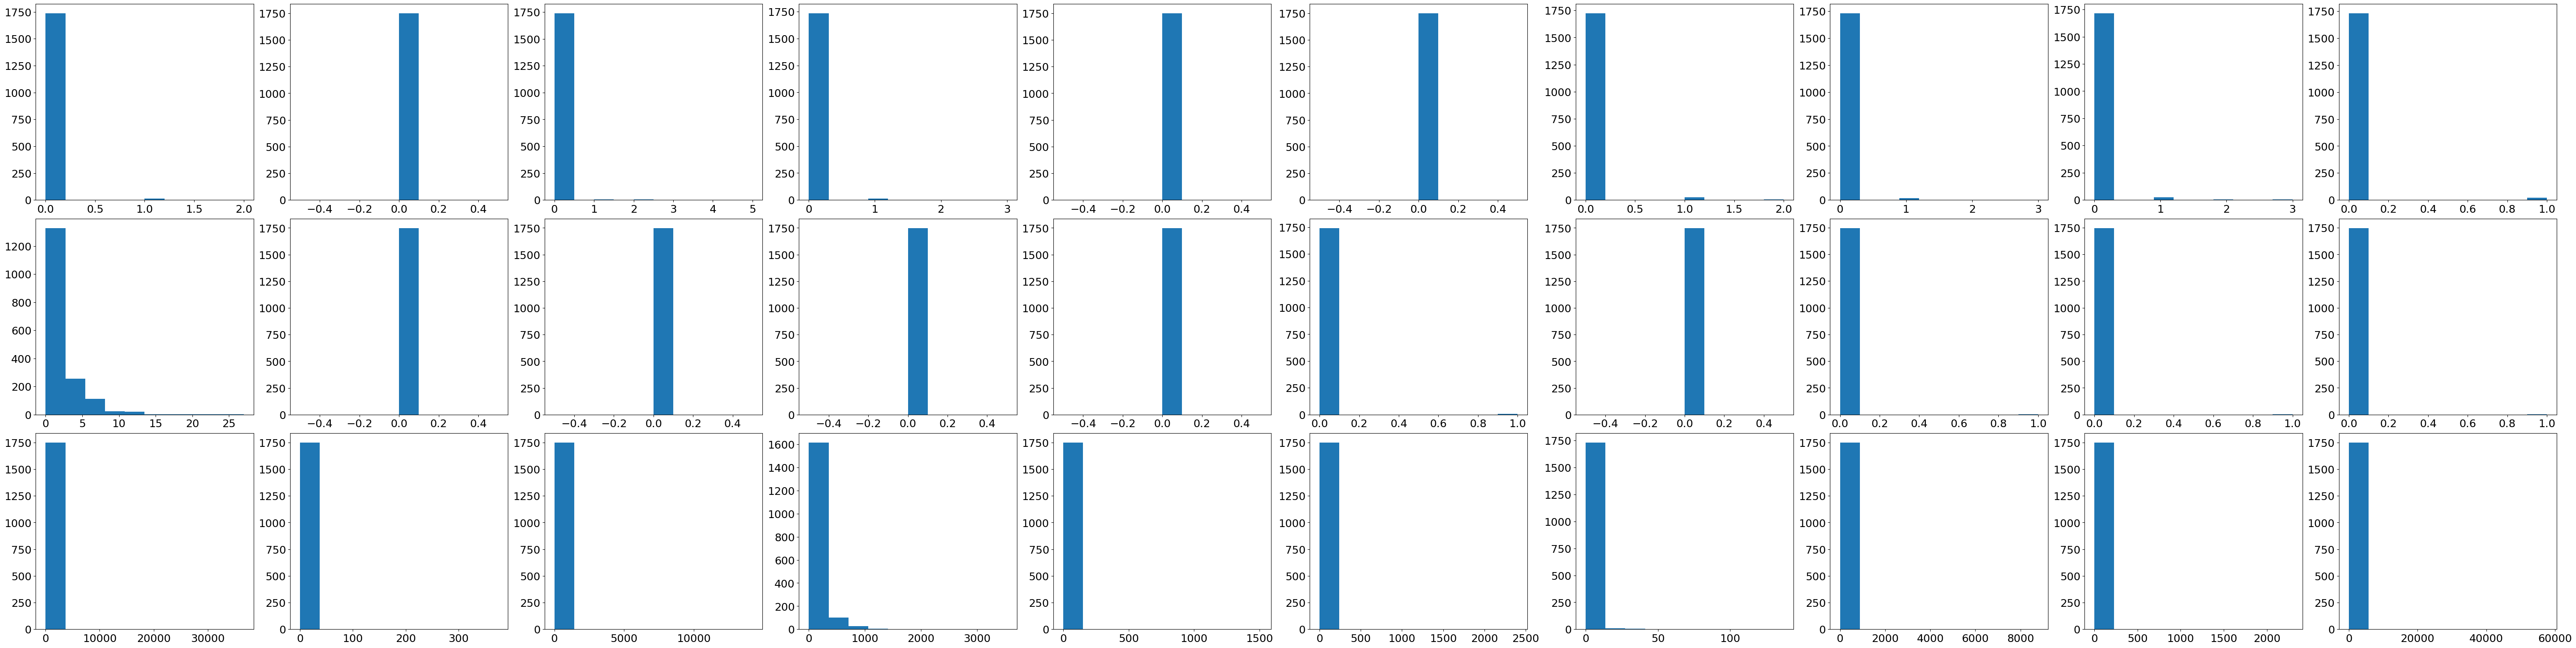

In [90]:
fig,ax = plt.subplots(3,10,figsize=(60,15))
for i in range(10):
    ax[0,i].hist(U[:,i])
    ax[1,i].hist(S[:,i])
    ax[2,i].hist(P[:,i])

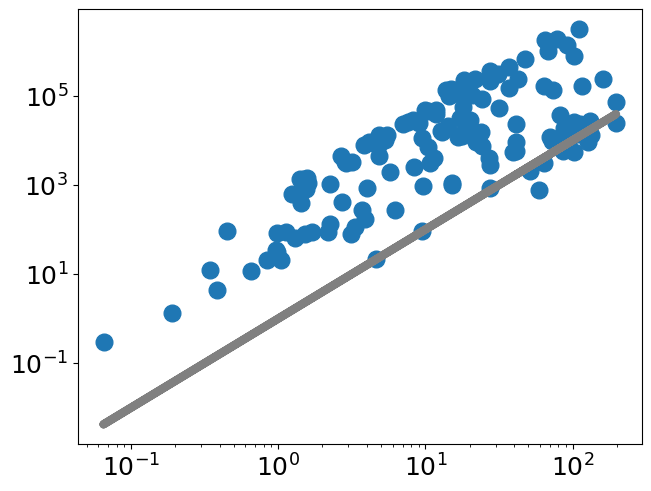

In [91]:
plt.scatter(P.mean(0),P.var(0))
plt.loglog(P.mean(0),P.mean(0)**2,'gray')

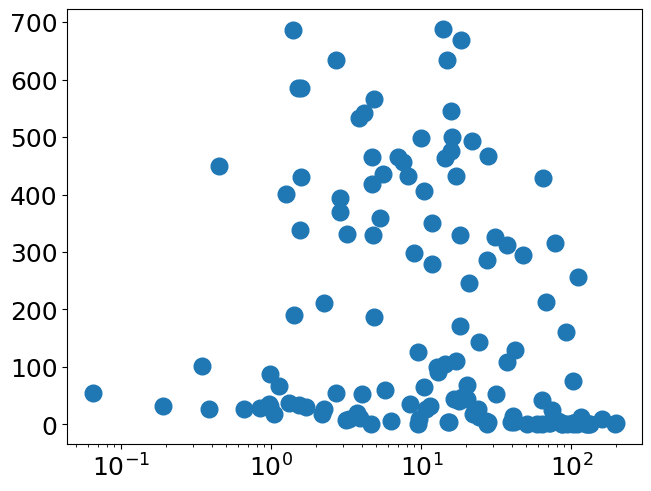

In [92]:
plt.scatter(P.mean(0),(P.var(0)-P.mean(0))/P.mean(0)**2)
plt.xscale('log')

In [115]:
iidx = (np.mean(U,axis=0)>0.1) &  (np.mean(S,axis=0)>0.1) &  (np.mean(P,axis=0)>100)
U = U[:,iidx]
S = S[:,iidx]
P = P[:,iidx]

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
P_mean = np.mean(P,axis=0)
P_var = np.var(P,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_pp = (P_var-P_mean)/P_mean**2
zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
cov_up = []
cov_ps = []
for i in range(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
    cov_up.append(np.cov(U[:,i],P[:,i])[0,1])
    cov_ps.append(np.cov(P[:,i],S[:,i])[0,1])
    
zeta_us = (np.array(cov_us)/U_mean/S_mean)
zeta_up = (np.array(cov_up)/U_mean/P_mean)
zeta_sp = (np.array(cov_ps)/P_mean/S_mean)
zeta_uu

array([3.5245233, 2.0745041, 1.2829124, 2.9934638, 1.09895  ],
      dtype=float32)

## $Cov(N_u,N_p)$ 
$$ \gamma_p \zeta_{us} = (\gamma_p + \beta) \zeta_{up} $$  

In [116]:
zeta_up,zeta_us

(array([1.14075432, 1.06414888, 0.41952305, 0.99311844, 0.51476097]),
 array([1.40301134, 1.69782207, 0.60480883, 1.40069478, 0.69497625]))

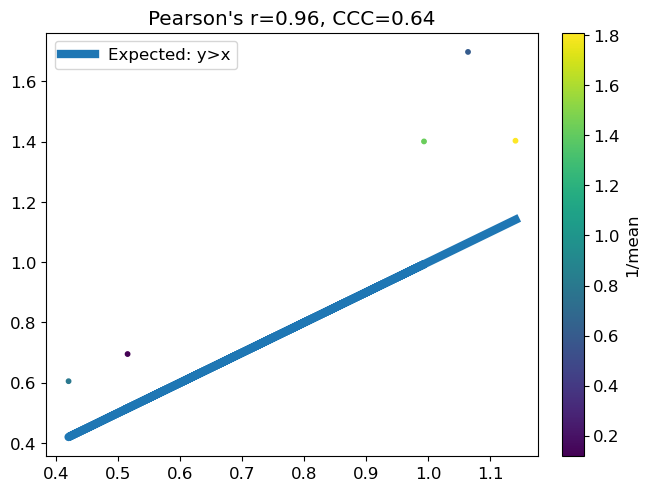

In [117]:
x=zeta_up
y=zeta_us

plt.plot(x,x,zorder=0,label='Expected: y>x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

## $Cov(N_s,N_p)$ 

$$\gamma (\zeta_{up}-\zeta_{sp}) + \gamma_p (\zeta_{ss}-\zeta_{sp}) = -\frac{\gamma_p}{\overline{X_s}} $$

In [118]:
zeta_up-zeta_sp,(zeta_up-zeta_sp)*(zeta_ss-zeta_sp)

(array([-0.14480307, -0.40750326, -0.05964225, -0.11981217,  0.05298141]),
 array([-0.16174533, -0.74632918, -0.0586095 , -0.03938117,  0.02168895]))

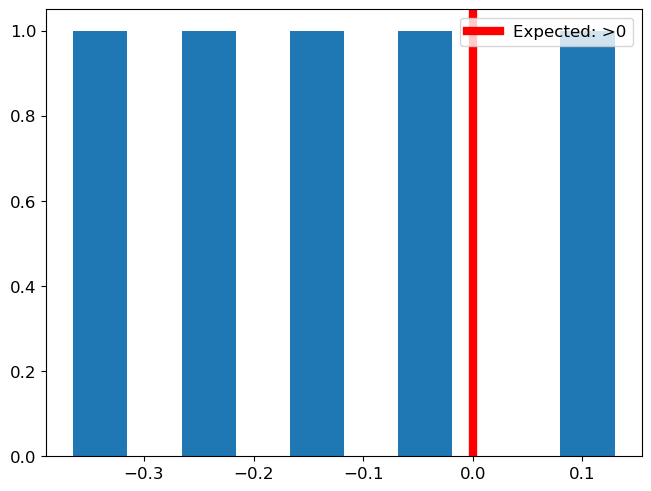

In [119]:
plt.hist((zeta_up-zeta_sp)/(zeta_ss-zeta_sp));
plt.axvline(x=0,c='r',label='Expected: >0')
plt.legend()

## $Var(N_p)$ 
$$ \zeta_{sp} = \zeta_{pp} $$  

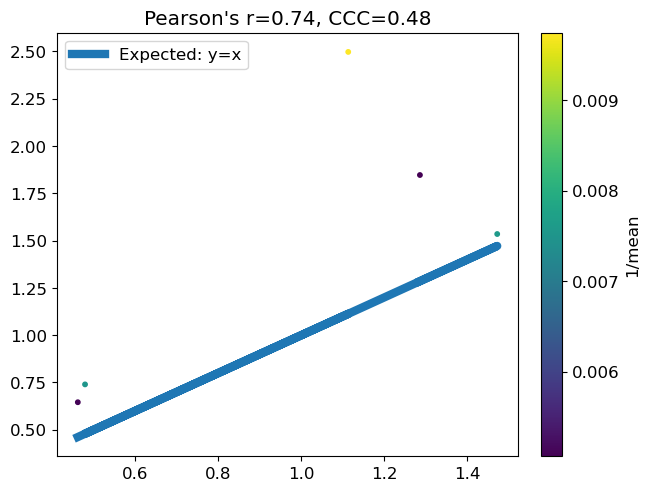

In [120]:
x=zeta_sp
y=zeta_pp

plt.plot(x,x,zorder=0,label='Expected: y=x')
plt.scatter(x,y,s=10,alpha=1,c=1/P_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()